In [1]:
import os
from os.path import join, basename, dirname
import cv2
import skimage.io
from tqdm.notebook import tqdm
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import glob
import multiprocessing
from multiprocessing.pool import Pool
from PIL import Image
import pandas as pd
import time
import matplotlib
import scipy
from sklearn.model_selection import StratifiedKFold

Image.MAX_IMAGE_PIXELS = None

%matplotlib inline

In [2]:
df = pd.read_csv('../data/train.csv').set_index('image_id')
TRAIN = '../data/train_images/'
MASK = '../data/image_masks'
OUT_TRAIN = '../data/train_images_tiles_36_256x256_row_major'
os.makedirs(OUT_TRAIN, exist_ok=True)
TRAIN_FILES = glob.glob(os.path.join(TRAIN, '*_1.jpeg'))
sz = 64
N = 36

In [4]:
def tile(img):
    result = []
    shape = img.shape
    pad0, pad1 = (sz - shape[0] % sz) % sz, (sz - shape[1] % sz) % sz
    img = np.pad(img, [[pad0 // 2,pad0 - pad0 // 2], [pad1 // 2, pad1 - pad1 // 2], \
                      [0,0]], constant_values=255)
    img = img.reshape(img.shape[0] // sz, sz, img.shape[1] // sz, sz, 3)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, sz, sz, 3)
    if len(img) < N:
        img = np.pad(img,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=255)
    idxs = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:N]
    img = img[idxs]
    for i in range(len(img)):
        result.append({'img':img[i], 'idx':idxs[i]})
    return result

In [5]:
def tile_v2(img, pixel_th=0.1):
    result = []
    shape = img.shape
    pad0, pad1 = (sz - shape[0] % sz) % sz, (sz - shape[1] % sz) % sz
    img = np.pad(img, [[pad0 // 2,pad0 - pad0 // 2], [pad1 // 2, pad1 - pad1 // 2], \
                      [0,0]], constant_values=255)
    img = img.reshape(img.shape[0] // sz, sz, img.shape[1] // sz, sz, 3)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, sz, sz, 3)
    max_sum = 255*sz*sz*3
    img_sums = img.reshape(img.shape[0],-1).sum(-1)
    topk = (img_sums < (1-pixel_th)*max_sum).sum()
    idxs = np.argsort(img_sums)[:topk]
    img = img[idxs]
    for i in range(len(img)):
        result.append({'img':img[i], 'idx':idxs[i]})
    return result

4


Text(0.5, 1.0, 'biopsy image')

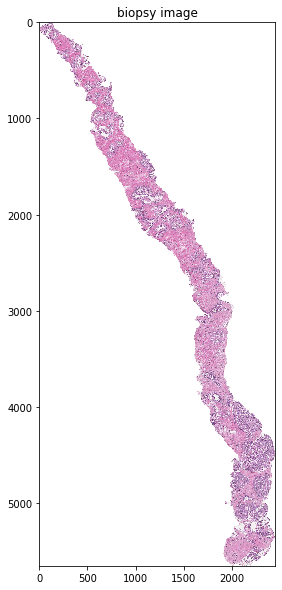

In [40]:
# visualising the masks generated
# seed = 5
# np.random.seed(seed)
sample = '../data/train_images/f8904c574ab1559e37f7399803b09dfd_1.jpeg'
# sample = np.random.choice(TRAIN_FILES)
sample2 = sample[:-7] + '_2.jpeg'
img = skimage.io.imread(sample)
img2 = skimage.io.imread(sample2)

print(df.loc[basename(sample[:-7])]['isup_grade'])

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img)
ax.set_title('biopsy image')

# fig, ax = plt.subplots(figsize=(10,10))
# ax.imshow(img2)
# ax.set_title('biopsy image 2')

# tiles = tile_v2(img2)
# tiles = sorted(tiles, key=lambda x: x['idx'])
# num_tiles = len(tiles)

# rows = int(np.sqrt(num_tiles))
# cols = num_tiles//rows + 1 if num_tiles % rows != 0 else num_tiles//rows
# fig, axes = plt.subplots(rows, cols, figsize=(10,10), sharex=True, sharey=True)
# for n in range(num_tiles):
#     i = n // cols
#     j = n % cols
#     axes[i,j].imshow(tiles[cols * i + j]['img'])
# fig.tight_layout()
# for ax in fig.get_axes():
#     ax.label_outer()

# Masks

Text(0.5, 1.0, 'biopsy mask')

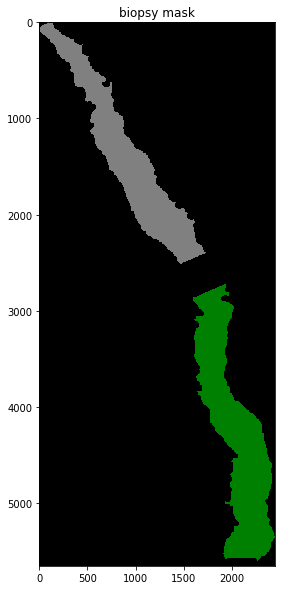

In [53]:
# mask_path = join(MASK, basename(sample[:-7] + '_mask_1.jpeg'))
# mask = skimage.io.imread(mask_path)[:,:,0]

data_provider = df.loc['f8904c574ab1559e37f7399803b09dfd']['data_provider']
mask_path = 'f8904c574ab1559e37f7399803b09dfd_mask_1.npz'
mask = scipy.sparse.load_npz(mask_path)
mask = mask.todense()

fig, ax = plt.subplots(figsize=(10,10))
if data_provider == 'karolinska':
    cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green'])
else:
    cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
ax.imshow(mask, cmap=cmap)
ax.set_title('biopsy mask')

# Visualising attention MAPS

In [3]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

from model import enet
from data_loader import PANDADataset, collate_fn
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler

device = torch.device('cuda')

In [4]:
enet_type = 'efficientnet-b0'
out_dim = 1
attn_dim = 256
model_path = '../trained_models/MIL_2stage_stage-1_enet_b0_64x64_fold-0_best.pth'
model = enet(enet_type, out_dim, attn_dim)
model = model.to(device)
state_dict = torch.load(model_path)
new_state_dict = {}
for k, v in state_dict.items():
    new_state_dict[k[7:]] = v
model.load_state_dict(new_state_dict)
model.eval()
print(f"Loaded model saved at {model_path}")

Loaded pretrained weights for efficientnet-b0
Loaded model saved at ../trained_models/MIL_2stage_stage-1_enet_b0_64x64_fold-0_best.pth


In [14]:
data_dir = '../data/'
image_folder = os.path.join(data_dir, 'train_images')
df_biopsy = pd.read_csv(os.path.join(data_dir, 'train.csv'), comment='#')

tile_size = 32
num_folds = 5
num_workers = 1
batch_size = 1
fold = 0
skf = StratifiedKFold(num_folds, shuffle=True, random_state=42)
df_biopsy['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_biopsy, df_biopsy['isup_grade'])):
    df_biopsy.loc[valid_idx, 'fold'] = i

mean = [0.90949707, 0.8188697, 0.87795304]
std = [0.36357649, 0.49984502, 0.40477625]
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

df_valid = df_biopsy.loc[df_biopsy['fold'] == fold]

dataset_valid = PANDADataset(df_valid, tile_size, image_folder, \
    out_dim, 'eval', transform=transform_val)
valid_loader = DataLoader(dataset_valid,
                            batch_size=batch_size,
#                             sampler=SequentialSampler(dataset_valid),
                            num_workers=num_workers,
                            collate_fn=collate_fn,
                             shuffle=True)

data_provider    karolinska
isup_grade                1
gleason_score           3+3
Name: 7c75a0ddf67f2cca476d51ec8b95d60f, dtype: object


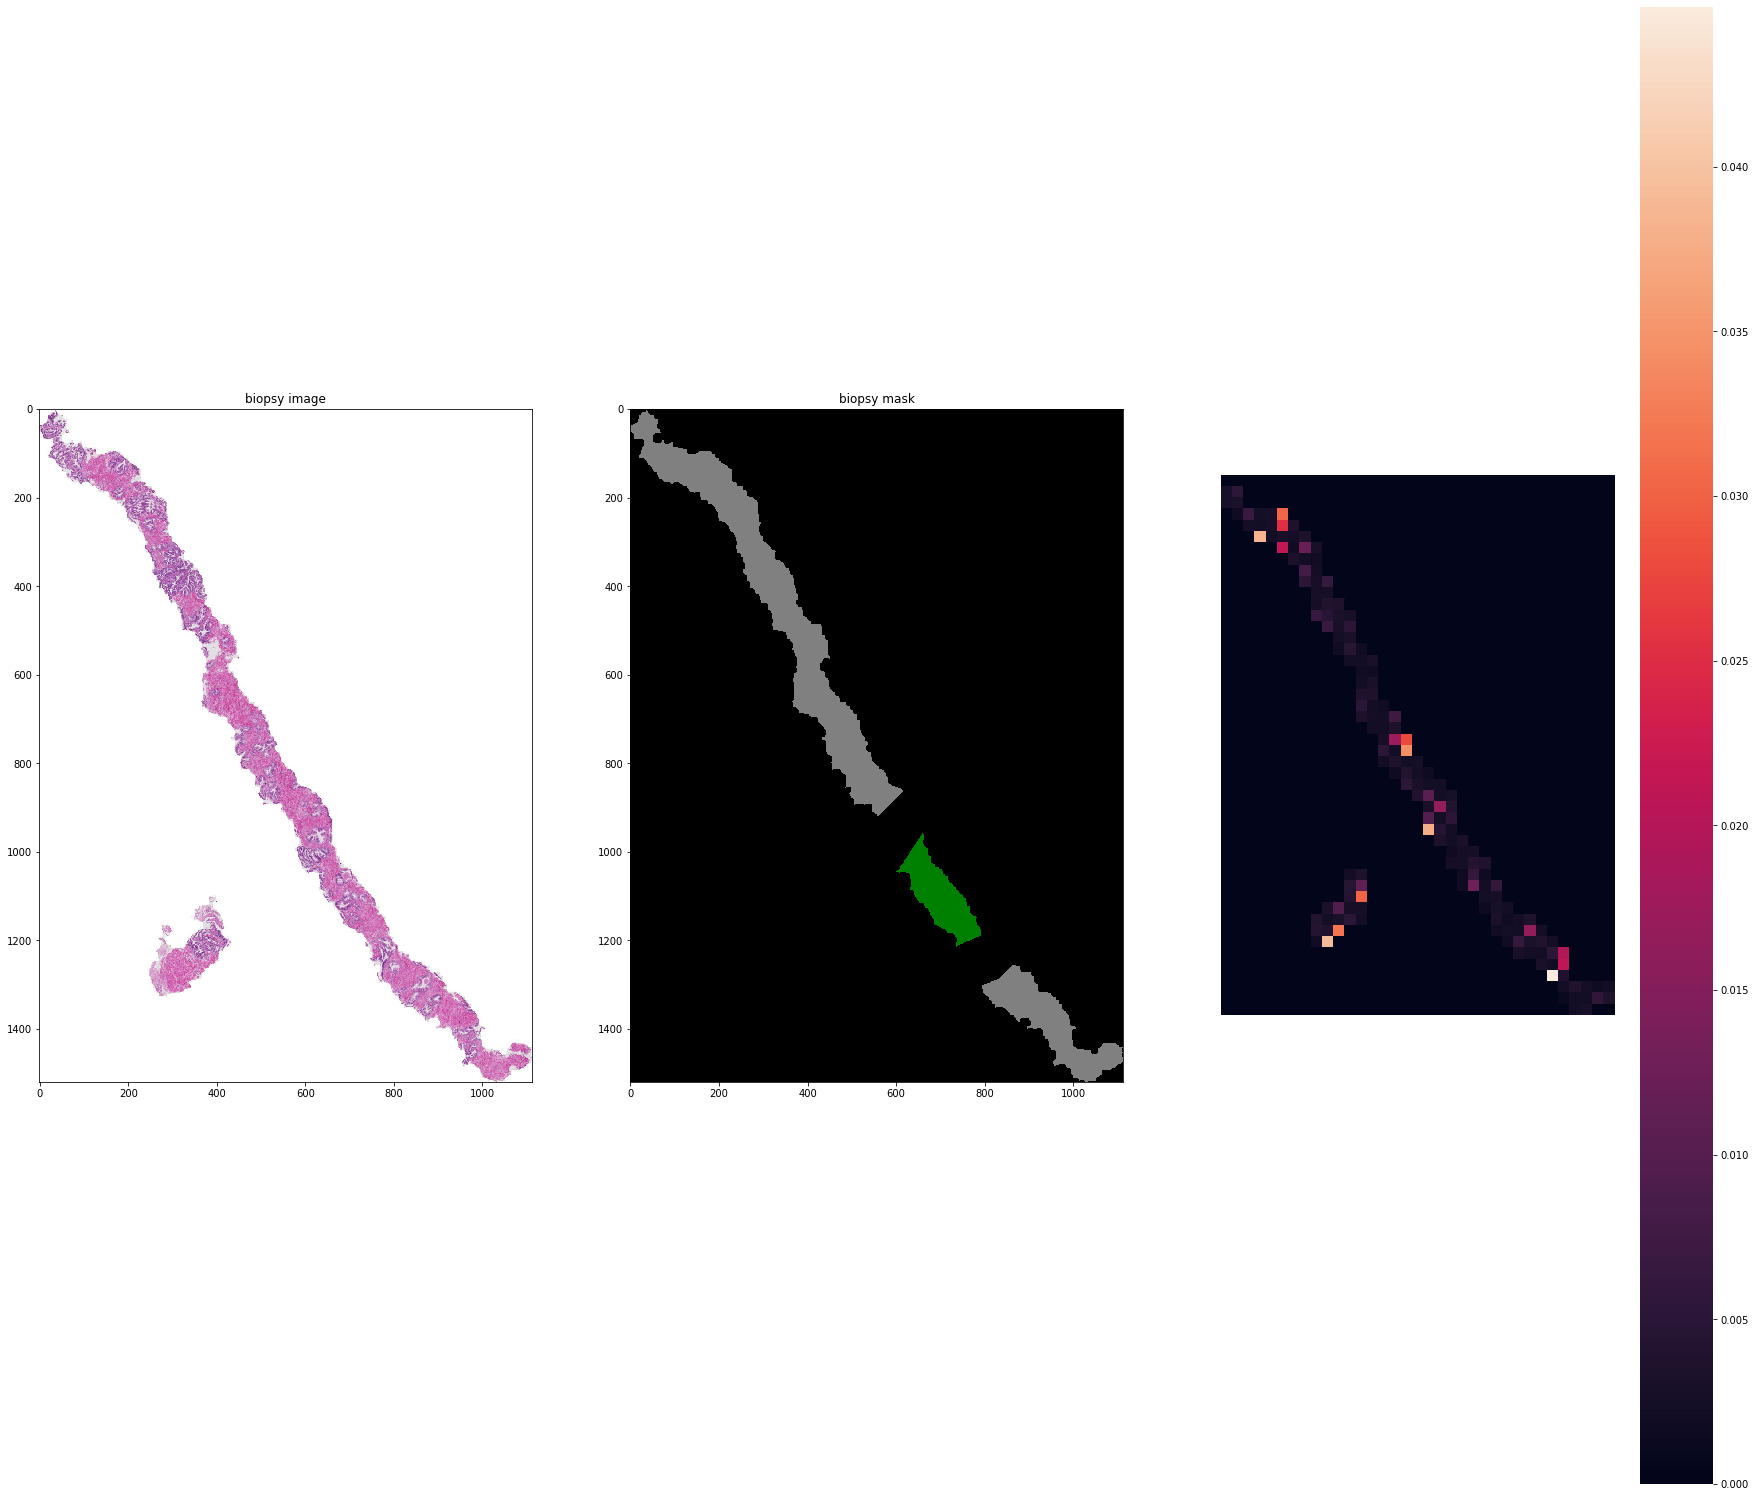

In [25]:
for batch in valid_loader:
    data, num_tiles, target, tile_indices, img_metadata = batch
    if target.item() == 1.0:
        break
data, target = data.to(device), target.to(device)
logits, attn_weights = model(data, num_tiles)
attn_weights = attn_weights.cpu().detach().numpy()

img_id = img_metadata[0][0]
rows, cols = img_metadata[0][1]
sample = '../data/train_images/' + img_id + '_2.jpeg'
img = skimage.io.imread(sample)

print(df.loc[basename(sample[:-7])])

fig, ax = plt.subplots(1,3,figsize=(30,30))
ax[0].imshow(img)
ax[0].set_title('biopsy image')

data_provider = df.loc[img_id]['data_provider']
mask_path = '../data/image_masks/' + img_id + '_mask_2.npz'
mask = scipy.sparse.load_npz(mask_path)
mask = mask.todense()

if data_provider == 'karolinska':
    cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green'])
else:
    cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
ax[1].imshow(mask, cmap=cmap)
ax[1].set_title('biopsy mask')

rows, cols = int(rows), int(cols)
attn_graph = np.zeros((rows, cols))
for attn, idx in zip(attn_weights, tile_indices[0]):
    r = idx // cols
    c = idx % cols
    attn_graph[r,c] = attn
import seaborn as sns
ax = sns.heatmap(attn_graph, square=True, xticklabels=False, yticklabels=False)#, vmin=0, vmax=1)
plt.show()